In [1]:
import sys
sys.path.insert(0, "../../")
import torch
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')

%load_ext autoreload
%autoreload 2

# Reweighing based on proximity

We get some simple timeseries

In [4]:
t = torch.linspace(0, 4 * torch.pi, 100)


def f(t):
    noise = torch.randn(100) * 0.1
    return torch.sin(t) + noise


x = f(t)

And let's create a filter that smooths the signal by taking in the neighbouring signals

In [5]:
# initialize a convolution
conv = torch.nn.Conv1d(1, 1, 8)

# build a gaussian kernel
n = torch.distributions.normal.Normal(0, 1)
v = torch.arange(-4, 4)
gaussian = torch.exp(n.log_prob(v))[None, None, :]

# replace the random weights
d = conv.state_dict()
d["weight"] = gaussian
conv.load_state_dict(d)
x_ = conv(x[None, None, :])[0][0]


We can plot everything like this:

Text(0.5, 1.0, 'smoothed')

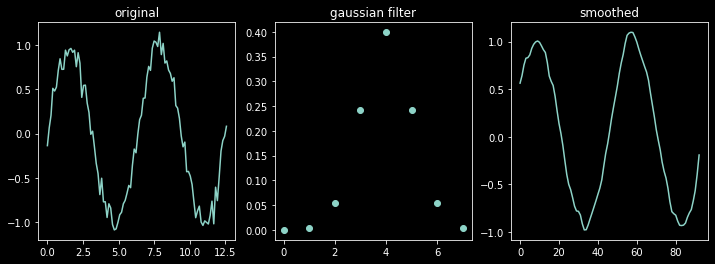

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].plot(t, x)
ax[0].set_title("original")

ax[1].scatter([*range(8)], gaussian[0][0])
ax[1].set_title("gaussian filter")

ax[2].plot(x_.detach())
ax[2].set_title("smoothed")


So, you see a noisy signal. The gaussian filter takes adds more of the close values, and less of the values further away. The filter works on the direct neighborhood.

# Text

Now, we consider text.

In [9]:
from src.models import tokenizer

corpus = ["ik zit op de bank", "ik werk bij de bank", "bij de bank is het heel druk"]
v = tokenizer.build_vocab(corpus, max=11)


2022-05-31 10:01:35.428 | INFO     | src.models.tokenizer:build_vocab:27 - Found 11 tokens


Now, the problem with text is: it is not necessarily the words that are close, that have the most impact.

In [300]:
v["bank"], v["test"], len(v)


(6, 1, 13)

In [10]:
x = tokenizer.tokenize(corpus, v)
x


tensor([[ 4,  6,  7,  2,  3,  0,  0],
        [ 4,  8,  5,  2,  3,  0,  0],
        [ 5,  2,  3,  9, 10, 11, 12]])

Our sentences are being encoded, and the word "bank" gets the integer 6 assigned. However, the meaning of this word is not the same because of the context... If we make an embedding:

In [12]:
import torch.nn as nn

emb = nn.Embedding(num_embeddings=len(v), embedding_dim=4, padding_idx=0)

embeddings = emb(x)

embeddings


tensor([[[ 0.1184,  1.2048, -0.0683, -0.0593],
         [ 0.3492, -0.4687,  0.0506,  0.8521],
         [ 0.4182,  1.2231,  0.1768,  0.3075],
         [-1.2157, -0.4323, -0.2292,  2.2078],
         [ 0.4787, -0.0661, -0.5252, -0.6401],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.1184,  1.2048, -0.0683, -0.0593],
         [-0.7699,  0.9004,  0.3742, -1.2342],
         [-0.3780,  3.0079,  0.5870,  0.3551],
         [-1.2157, -0.4323, -0.2292,  2.2078],
         [ 0.4787, -0.0661, -0.5252, -0.6401],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[-0.3780,  3.0079,  0.5870,  0.3551],
         [-1.2157, -0.4323, -0.2292,  2.2078],
         [ 0.4787, -0.0661, -0.5252, -0.6401],
         [-0.8357, -0.2906,  1.5244, -0.3037],
         [ 0.3687,  1.0751,  0.5684, -0.0968],
         [-0.9128,  0.7389, -0.4988,  1.1443],
         [ 0.8079,  0.7405, -0.2328,  0.6101]]], grad_fn

You can see that the word "bank" gets exactly the same vector, as expected...

In [27]:
bank1 = embeddings[0][4]
bank2 = embeddings[1][4]
bank1, bank2


(tensor([ 0.4787, -0.0661, -0.5252, -0.6401], grad_fn=<SelectBackward0>),
 tensor([ 0.4787, -0.0661, -0.5252, -0.6401], grad_fn=<SelectBackward0>))

# Attention
Now we will start with the attention mechanism.
We need a key, query and value. Because we use self attention, these are just clones.

In [15]:
key = embeddings.detach().clone()
query = embeddings.detach().clone()
values = embeddings.detach().clone()
key.shape


torch.Size([3, 7, 4])

We have 4 features

In [16]:
d_features = torch.tensor(query.shape[-1])
d_features

tensor(4)

And with this, we can calculate $$\frac{(QK^T)}{\sqrt{d}}$$

In [18]:
dots = torch.bmm(query, key.transpose(1, 2)) / torch.sqrt(d_features)
dots.shape


torch.Size([3, 7, 7])

We obtain the weights with a softmax:

In [19]:
weights = nn.Softmax(dim=-1)(dots)

weights[0]


tensor([[0.2415, 0.0866, 0.2438, 0.0783, 0.1186, 0.1156, 0.1156],
        [0.0882, 0.2011, 0.1089, 0.2685, 0.0977, 0.1178, 0.1178],
        [0.2286, 0.1002, 0.2661, 0.0888, 0.0995, 0.1084, 0.1084],
        [0.0204, 0.0687, 0.0247, 0.8139, 0.0120, 0.0301, 0.0301],
        [0.1519, 0.1228, 0.1360, 0.0588, 0.2344, 0.1481, 0.1481],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429]])

and finally we can do a matrix-multiplication with the values:

$$attention = softmax\left(\frac{(QK^T)}{\sqrt{d}}\right)V$$

In [20]:
activations = torch.bmm(weights, values)
activations.shape, embeddings.shape


(torch.Size([3, 7, 4]), torch.Size([3, 7, 4]))

note how we end up with exactly the same size.

In [28]:
bank1 = activations[0][4]
bank2 = activations[1][4]
bank1, bank2


(tensor([ 0.1584,  0.2508, -0.1167,  0.1173]),
 tensor([-0.1010,  0.5711, -0.0320, -0.1952]))

Now, the vector for the word bank has been "mixed" with all the other words in the sentence.

torch has a multihead attention implemented. With that, we can add a mask to cover the padding.

In [29]:
mask = x == 0
mask.shape


torch.Size([3, 7])

In [30]:
multihead = nn.MultiheadAttention(embed_dim=4, num_heads=2, batch_first=True)
attn, attn_w = multihead(query, key, values, key_padding_mask=mask)


In [31]:
attn.shape


torch.Size([3, 7, 4])

It is possible to visualize the weights. In this case, this is untrained.
What you expect is that e.g. the vector for the word "bank" should be mixed with the word "zit" (sit) to make more sense.

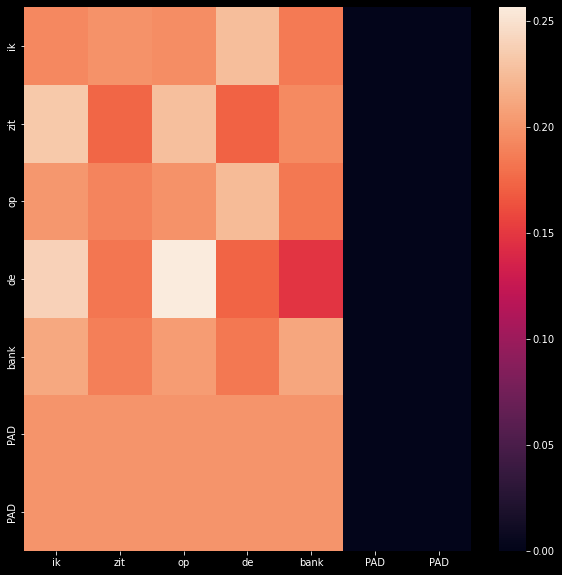

In [52]:
import seaborn as sns

plt.figure(figsize=(10, 10))
labels = corpus[0].split()
labels = labels + ["PAD", "PAD"]

plot = sns.heatmap(attn_w[0].detach().numpy())

plot.set_xticklabels(labels);
plot.set_yticklabels(labels);

# Positional Encoding
A final ingredient is positional encoding.

With Attention we loose all sense of location in a sentence. A way around this is to add positional encoding:

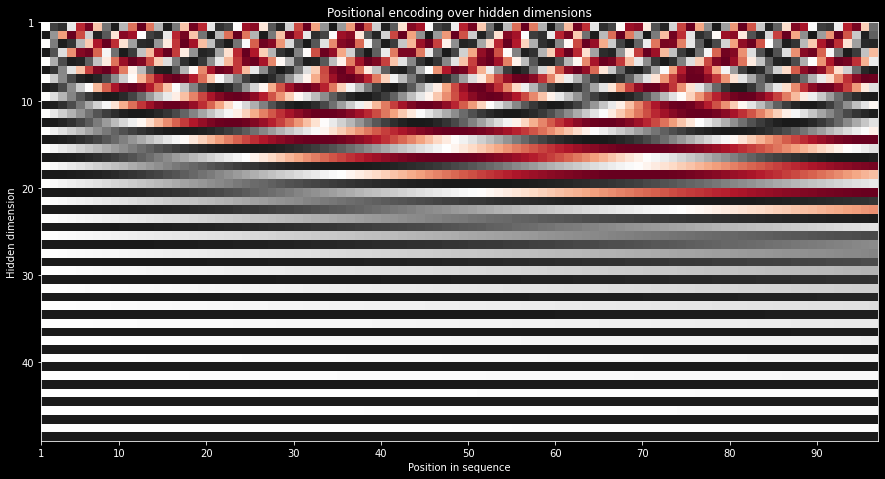

In [57]:
import math


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer("pe", pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)]
        return x

encod_block = PositionalEncoding(d_model=48, max_len=96)
pe = encod_block.pe.squeeze().T.cpu().numpy()

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.imshow(pe, cmap="RdGy", extent=(1, pe.shape[1] + 1, pe.shape[0] + 1, 1))
# fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_xticks([1] + [i * 10 for i in range(1, 1 + pe.shape[1] // 10)])
ax.set_yticks([1] + [i * 10 for i in range(1, 1 + pe.shape[0] // 10)])
plt.show()


The idea is to add multiple sine waves.
One sinewave will have a very fast frequency, another sinewave will have a slow frequency.
Note that this is exactly how our time-system works: minutes have a fast frequency, hours a slower one, days of the week even slower etc.

By combining a lot of sinewaves the model is able to figure out something about the location in time, relative to each other. 